<a href="https://colab.research.google.com/github/Samuela31/Deep-Learning-Laboratory/blob/main/DL_Lab_10_Fine_Tuning_a_small_Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
!pip install --upgrade keras

We upgrade Keras because ops from Keras needs Keras 3 but colab uses Keras 2

In [ ]:
#Two  embedding layers, one for tokens, one for token index (positions).
from keras import ops
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [ ]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 200, 32)             │         646,400 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 200, 32)             │          10,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657,758 (2.51 MB)

 Trainable params: 657,758 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val)
)

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 167ms/step - accuracy: 0.6997 - loss: 0.5295 - val_accuracy: 0.8801 - val_loss: 0.2859
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 154ms/step - accuracy: 0.9299 - loss: 0.1915 - val_accuracy: 0.8695 - val_loss: 0.3157


In [ ]:
# Get the final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Training Accuracy: 0.9276
Final Validation Accuracy: 0.8695


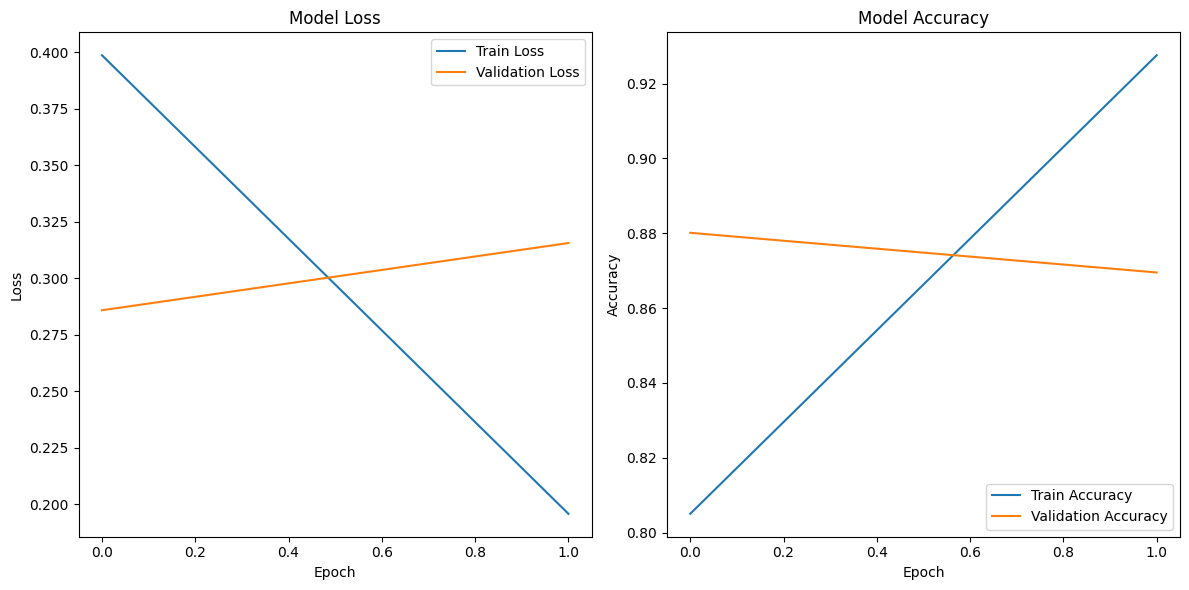

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer

# Load the tokenizer used during training
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom input text
custom_text = "I absolutely hated this movie, it was horrible!"
#custom_text = "Amazing!"

# Tokenize the input text
inputs = tokenizer.encode_plus(
    custom_text,
    add_special_tokens=True,
    max_length=200,  # Adjust the max_length as per your model's requirement
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Extract the input tensors
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Make predictions
predictions = model.predict([input_ids])

# Interpret the prediction for binary classification
print(predictions.shape)

# Interpret the prediction for binary classification
# If the model outputs a single probability value for positive sentiment
if predictions.shape == (1, 1):
    predicted_class = 'negative' if predictions[0][0] > 0.5 else 'positive'
    print(predictions[0][0])
# If the model outputs probabilities for two classes
elif predictions.shape == (1, 2):
    predicted_class = 'negative' if predictions[0][1] > predictions[0][0] else 'positive'
    print(predictions[0][1])
else:
    raise ValueError("Unexpected output shape from model")

print(f"The sentiment of the text \"{custom_text}\" is: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 2)
0.71644276
The sentiment of the text "I absolutely hated this movie, it was horrible!" is: negative
